In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2, json, itertools, tempfile
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dropout, BatchNormalization, GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import drive
from tensorflow import keras
from keras.models import load_model
%load_ext tensorboard

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
g_path = '/content/gdrive'
image_path = g_path + '/My Drive/Colab Notebooks' + '/archive'
image_dir_list = os.listdir(image_path)

print(image_dir_list)

['readme.txt', 'label_map.json', 'test.csv', 'validation.csv', 'train.csv', 'images_train_test_val', 'images']


### Analyse the data and classes

In [ ]:
im_dataset_path = image_path + "/images"
json_file_path = image_path + "/label_map.json"

with open(json_file_path,"r") as j_file:
    class_name_cats = json.load(j_file)

len_classes = len(class_name_cats)
out_classes = list(class_name_cats.keys())
class_name_cats

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'harbor': 20,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19}

### Load image dataset

In [ ]:
def load_image_data(csv_file):
    images_arr = []
    labels_arr = []
    img_csv = pd.read_csv(csv_file,index_col="Unnamed: 0")

    for i in tqdm(range(img_csv.shape[0])):
        image_name = img_csv.loc[i,'Filename']
        image = load_img(os.path.join(im_dataset_path,image_name),target_size=(224,224))

        image = img_to_array(image)
        image = preprocess_input(image)
        label = img_csv.loc[i,'Label']
        
        images_arr.append(image)
        labels_arr.append(label)
    
    images_arr = np.array(images_arr)
    labels_arr = np.array(labels_arr)
    return images_arr, labels_arr

In [ ]:
train_im_path = image_path + "/train.csv"
val_im_path = image_path + "/validation.csv"
test_im_path = image_path + "/test.csv"

train_imgs, train_classes = load_image_data(train_im_path)
val_imgs, val_classes = load_image_data(val_im_path)
test_imgs, test_classes = load_image_data(test_im_path)

train_imgs.shape, train_classes.shape, val_imgs.shape, val_classes.shape, test_imgs.shape, test_classes.shape

100%|██████████| 1050/1050 [06:01<00:00,  2.90it/s]


((7350, 224, 224, 3),
 (7350,),
 (2100, 224, 224, 3),
 (2100,),
 (1050, 224, 224, 3),
 (1050,))

In [ ]:
train_classes = to_categorical(train_classes)
val_classes = to_categorical(val_classes)
test_classes = to_categorical(test_classes)

print(train_classes.shape)
print(val_classes.shape)
print(test_classes.shape)

(7350, 21)
(2100, 21)
(1050, 21)


### MobilenetV2 Model

In [ ]:
MobileNetV2_model = tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224, 224, 3),include_top=False)

# Add pooling layer
inputs = MobileNetV2_model.output
inputs = GlobalAveragePooling2D()(inputs)

# Add dropout layer
inputs = Dropout(0.5)(inputs)

# Add fully-connected dense layer
inputs = Dense(1024, activation='relu')(inputs)

# Add Softmax Layer for outputs classes
preds = Dense(21, activation='softmax')(inputs)
model = Model(inputs=MobileNetV2_model.input, outputs=preds)

9420800/9406464 [==============================] - 0s 0us/step


### Compile Model

In [ ]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Plot Model network

In [ ]:
# plot_model(model,to_file='MobileNet_transfer_model.png',show_shapes=True,show_layer_names=True)
# SVG(model_to_dot(model).create(prog='dot',format='svg'))

### Train Model

In [ ]:
epochs = 10
batchSize = 10

history = model.fit(train_imgs, train_classes,
                      steps_per_epoch=len(train_imgs)//batchSize,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(val_imgs, val_classes),
                      validation_steps=len(val_imgs)//batchSize)
                      # callbacks=[MobileNet_checkpoint, MobileNet_logs])

Epoch 1/10
735/735 [==============================] - 48s 65ms/step - loss: 0.0960 - accuracy: 0.9727 - val_loss: 0.2620 - val_accuracy: 0.9419
Epoch 2/10
735/735 [==============================] - 47s 64ms/step - loss: 0.1231 - accuracy: 0.9645 - val_loss: 0.8546 - val_accuracy: 0.8414
Epoch 3/10
735/735 [==============================] - 47s 64ms/step - loss: 0.1108 - accuracy: 0.9714 - val_loss: 0.6510 - val_accuracy: 0.8543
Epoch 4/10
735/735 [==============================] - 47s 64ms/step - loss: 0.0962 - accuracy: 0.9710 - val_loss: 0.4557 - val_accuracy: 0.9152
Epoch 5/10
735/735 [==============================] - 47s 64ms/step - loss: 0.1000 - accuracy: 0.9728 - val_loss: 0.4164 - val_accuracy: 0.9124
Epoch 6/10
735/735 [==============================] - 47s 64ms/step - loss: 0.1140 - accuracy: 0.9702 - val_loss: 0.8360 - val_accuracy: 0.8438
Epoch 7/10
735/735 [==============================] - 47s 64ms/step - loss: 0.1027 - accuracy: 0.9722 - val_loss: 1.9311 - val_accuracy:

### Show history of traning and validation Accuracy

In [ ]:
def summarize(history):
    
    plt.style.use("ggplot")
    fig, axes = plt.subplots(1,2,figsize=(16,6))

    #Plot loss     
    axes[0].set_title('Cross Entropy Loss')
    axes[0].plot(history.history['loss'], color='blue', label="Train")
    axes[0].plot(history.history['val_loss'], color='orange', label="Validation")
    axes[0].legend(loc='upper right')

    #Plot Accuracy 
    axes[1].set_title('Classification Accuracy')
    axes[1].plot(history.history['accuracy'], color='blue', label="Train")
    axes[1].plot(history.history['val_accuracy'], color='orange', label="Validation")
    axes[1].legend(loc='lower right')
    
    plt.show();
    pass

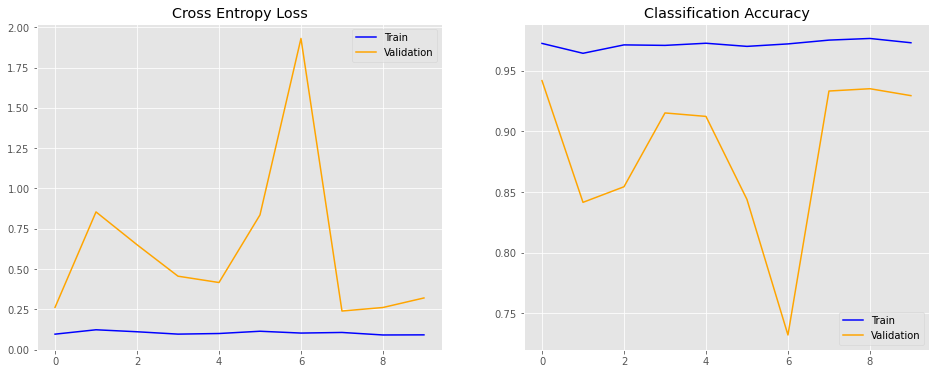

In [ ]:
summarize(history)

### Validation and Confusion Matrix

In [ ]:
def show_conf_matrix(conf_mtx, classes, cmap=plt.cm.Blues):
    
    conf_mtx = conf_mtx.astype('float')/conf_mtx.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(conf_mtx, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    marks = np.arange(len(classes))
    plt.xticks(marks, classes,rotation=90)
    plt.yticks(marks, classes)
    
    fmrt = '.2f'
    limit = conf_mtx.max()/2.0   
    for i,j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j,i, format(conf_mtx[i,j], fmrt),
                horizontalalignment = "center",
                color = "white" if conf_mtx[i,j] > limit else "black")
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);

In [ ]:
val_predict = model.predict(val_imgs)
val_predict = np.argmax(val_predict, axis=1)
val_predict.shape

(2100,)

<Figure size 432x288 with 0 Axes>

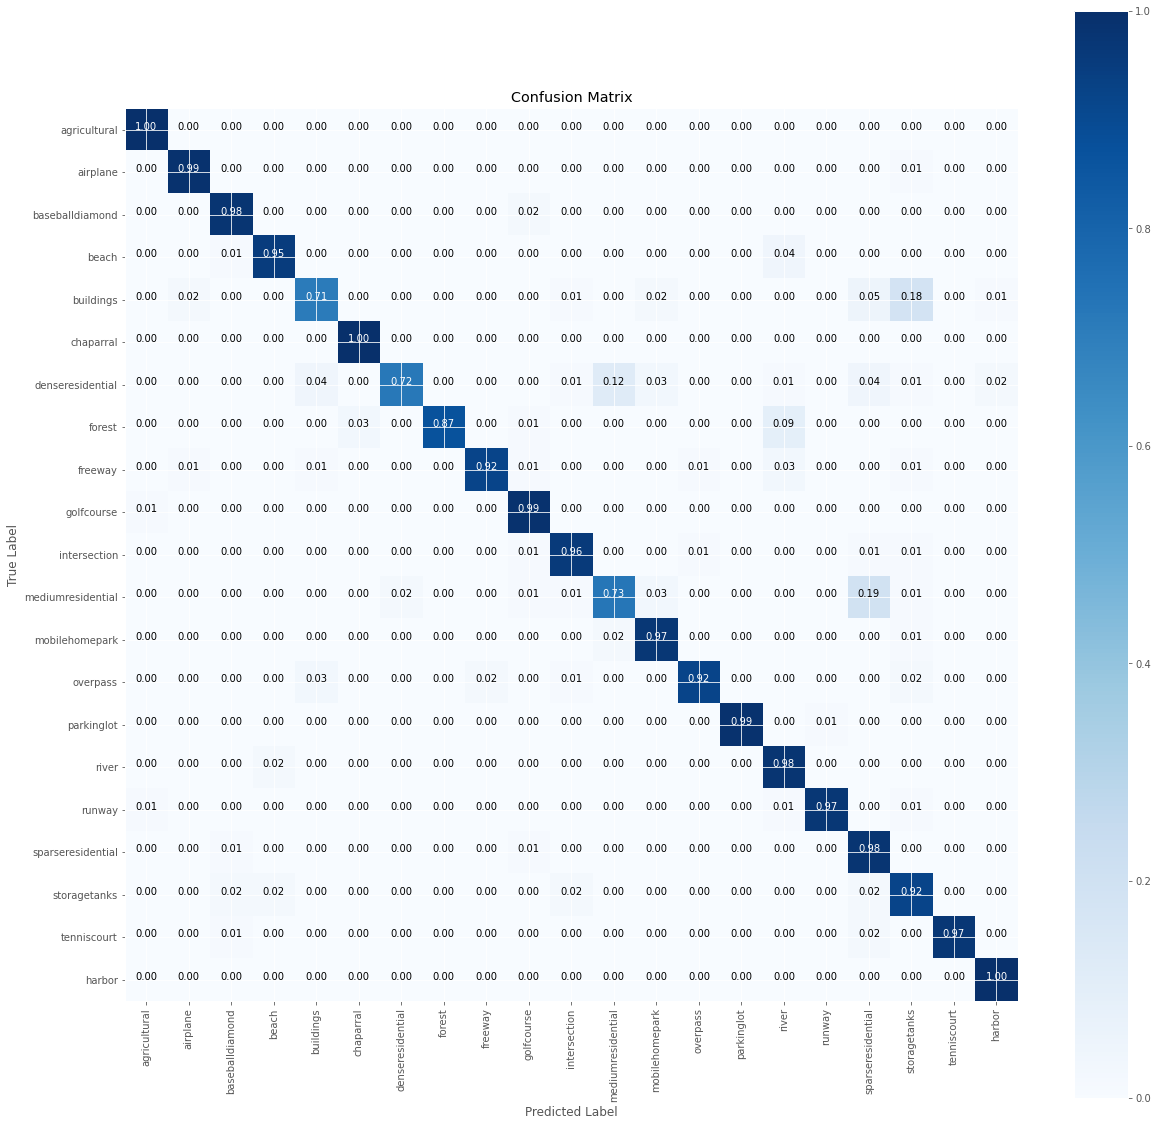

In [ ]:
val_actual = np.argmax(val_classes, axis=1)

conf_matrix = confusion_matrix(val_actual, val_predict)
np.set_printoptions(precision=2)

plt.figure()
show_conf_matrix(conf_matrix, classes=out_classes)
plt.grid(None)
plt.show()

### Make Predictions

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#Formula
# accuracy: (tp + tn) / (p + n)
MobileNetV2_Accuracy = accuracy_score(val_actual, val_predict)
print('MobileNetV2 - Validation Accuracy: %f' % MobileNetV2_Accuracy)

#Formula
# precision tp / (tp + fp)
MobileNetV2_precision = precision_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - Precision : %f' % MobileNetV2_precision)

#Formula
# recall: tp / (tp + fn)
MobileNetV2_recall = recall_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - Recall : %f' % MobileNetV2_recall)

#Formula
# f1: 2 tp / (2 tp + fp + fn)
MobileNetV2_f1_sc = f1_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - F1 score : %f' % MobileNetV2_f1_sc)

MobileNetV2 - Validation Accuracy: 0.929524
MobileNetV2 - Precision : 0.934609
MobileNetV2 - Recall : 0.929524
MobileNetV2 - F1 score : 0.928746


In [ ]:
_, model_base_acc = model.evaluate(
   test_imgs, test_classes, verbose=0)

print('Test accuracy for base:', model_base_acc) 

Test accuracy for base: 0.9314285516738892


### Save the model

In [ ]:
# model.save("/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/MobileNetV2_New_baseline.h5")

In [ ]:
model_fin_baseline = load_model('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/MobileNetV2_New_baseline.h5')

### Calculate Inference time

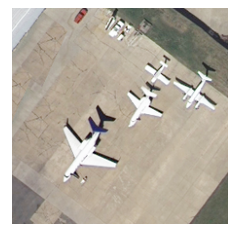

Predicted Class is: 1
Inference time is:  0.04561148900029366


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif')

# predict the class
start = time.perf_counter()
pre_class = model_fin_baseline.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
print("Inference time is: ", ir_time)

## Model Quantization 

#### Float-16 Quantization

In [ ]:
# Pass the Keras model to the TF Lite Converter
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model_fin_baseline)

# Using float-16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_fp16_model = converter.convert()

# Save the model
with open('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/fp_16_model.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpz4zpb80e/assets


INFO:tensorflow:Assets written to: /tmp/tmpz4zpb80e/assets


In [ ]:
actual_class=[]
for vals in val_classes:
  actual_val = np.argmax(vals)
  actual_class.append(actual_val)

actual_class=np.array(actual_class)

In [ ]:
#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']
 
  for i, test_image in enumerate(val_imgs):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)

    interpreter.set_tensor(input_index, test_image)


    # Run inference.
    start = time.perf_counter()
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])

    prediction.append(predicted_label)
    end = time.perf_counter()

    ir = end- start
    
    # print("Inference time:", ir)
   
  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)

  accuracy = np.sum(prediction == actual_class)/len(prediction)
  print(accuracy)

  return accuracy

In [ ]:
# Pass the FP-16 TF Lite model to the interpreter
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/fp_16_model.tflite')
# allocate tensor
interpreter.allocate_tensors()

# Evaluate the model on the test data
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', model_base_acc*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.


0.9295238095238095
Float 16 Quantized TFLite Model Test Accuracy: 92.95238095238095
Baseline Keras Model Test Accuracy: 93.14285516738892


### Dynamic Range Quantization


In [ ]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_fin_baseline)

# Use the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Converting the model
tflite_quant_model = converter.convert()

with open('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/dynamic_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp0l7xm433/assets


INFO:tensorflow:Assets written to: /tmp/tmp0l7xm433/assets


In [ ]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', model_base_acc*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.


0.93
Dynamically  Quantized TFLite Model Test Accuracy: 93.0
Baseline Keras Model Test Accuracy: 93.14285516738892


### Integer Quantization

In [ ]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_fin_baseline)
# Defining the representative dataset from training images.
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(val_imgs).batch(1).take(100):
    # print(input_value.shape)
    yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Converting the model.
int_quant_model = converter.convert()

# Saving the Integer Quantized TF Lite model.
with open('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/int_quant_model.tflite', 'wb') as f:
  f.write(int_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpsco09qes/assets


INFO:tensorflow:Assets written to: /tmp/tmpsco09qes/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
# Passing the Integer Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/H5/int_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', model_base_acc*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.


0.08571428571428572
Integer Quantized TFLite Model Test Accuracy: 8.571428571428571
Baseline Keras Model Test Accuracy: 93.14285516738892


## Inference Time

Inference on Single Image for inference time

In [25]:
#Function for evaluating TF Lite Model over Test Images
def evaluate_one(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']
 
  for i, test_image in enumerate(pred_img):
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)

    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    start = time.perf_counter()

    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])

    prediction.append(predicted_label)
    end = time.perf_counter()

    ir = end- start
    
    print("Inference time:", ir)

#### FP-16 Model

In [30]:
# Pass the FP-16 TF Lite model
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Quantized/MobileNetV2/fp_16_model.tflite')

# allocare tensor
interpreter.allocate_tensors()

# Test on single image
test_accuracy = evaluate_one(interpreter)

Inference time: 0.01884420900000805


#### Dynamic Range quantised Model

In [23]:
# Passing the Dynamic Range Quantized TF Lite model
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Quantized/MobileNetV2/dynamic_quant_model.tflite') 

# allocate tensor
interpreter.allocate_tensors()

#Test on single image
test_accuracy = evaluate_one(interpreter)

Inference time: 0.7721615660000225




#### Integer quantised Model

In [24]:
# Passing the Integer Quantized TF Lite model.
interpreter = tf.lite.Interpreter('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Quantized/MobileNetV2/int_quant_model.tflite')

# allocate tensor
interpreter.allocate_tensors()

#Test on single image
test_accuracy = evaluate_one(interpreter)

Inference time: 0.8623096000001169


